### <span style="color:teal"> __NETWORK ANALYSIS: DISEASE UNIPARTITE SPECIES NETWORK -- SPECIES LEVEL__
<span style="color:teal"> In a disease-centric unipartite species network, diseases are represented as nodes, and an edge is drawn between two diseases when they share one or more microbial species with statistically significant associations. This network is generated as a projection from an underlying disease–species bipartite network, where microbial species serve as the intermediates linking diseases. Similarly, a unipartite network can also be constructed for microbial taxa, where nodes represent species and edges indicate co-occurrence across diseases. These unipartite projections allow us to summarize complex bipartite relationships in a more intuitive form, highlighting patterns of shared dysbiosis among diseases or co-association among taxa. By focusing on disease–disease connections, the network reveals potential comorbidity patterns, identifies clusters of diseases with overlapping microbial signatures, and generates hypotheses about common pathophysiological mechanisms that may be mediated by the gut microbiome. This approach shifts the perspective from individual taxa to the broader relationships between diseases and taxa, providing a systems-level view of microbiome–host interactions.


In [1]:
# === Third-Party Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator
import json
import pickle

# NetworkX and Seaborn
import networkx as nx
from networkx.algorithms import bipartite
print("Network X version = ",nx.__version__)

#power-law
import powerlaw
from powerlaw import Fit

Network X version =  3.4.2


In [2]:
# LOADING SPECIES DATA
df_species = pd.read_csv("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/significant_species_taxa.txt", sep="\t")
df_species_network = df_species[["disease", "ncbi_taxon_id"]].drop_duplicates()

In [3]:
# LOADING DICTIONARY DISEASE NAMES AND DISEASE CATEGORIES

# Open the JSON file containing disease name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_dict.json", "r") as f:
    # Load the contents of the JSON file into a Python dictionary
    disease_dict = json.load(f)
    
# Open hte JSOn file contaiing the disease classificaiton data
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/disease_classification.json", "r") as f:
    disease_classification = json.load(f)

# Open the JSON file containing taxon name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/taxon_dict.json", "r") as f:
    # Load the contents of the JSON file into a Python dictionary
    taxon_dict = json.load(f)
    
# Open the JSON file containing taxon phyla classification name mappings
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/taxon_phyla_dict.json", "r") as f:
    # Load the contents of the JSON file into a Python dictionary
    taxon_phyla_dict = json.load(f)


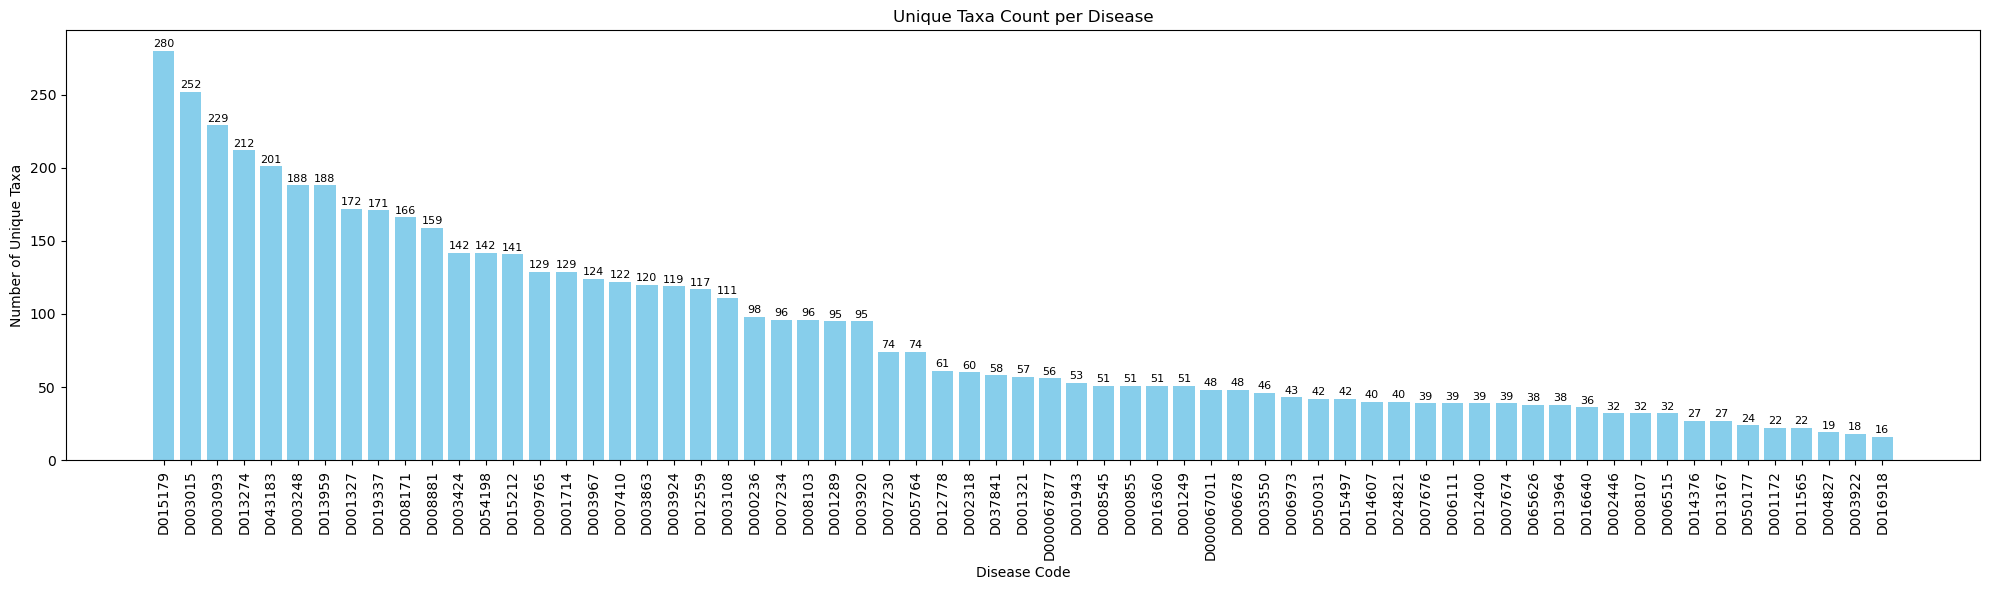

In [4]:
# Data Descritption
# Group and count unique taxa per disease
taxa_counts = (
    df_species_network.groupby("disease")["ncbi_taxon_id"]
    .nunique()
    .reset_index(name="unique_taxa_count")
    .sort_values("unique_taxa_count", ascending=False)
)

# Plot
fig, ax = plt.subplots(figsize=(20, 6))
bars = ax.bar(taxa_counts["disease"], taxa_counts["unique_taxa_count"], color="skyblue")

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,  # position above the bar
        str(height),
        ha='center',
        va='bottom',
        fontsize=8
    )

# Formatting
ax.set_xlabel("Disease Code")
ax.set_ylabel("Number of Unique Taxa")
ax.set_title("Unique Taxa Count per Disease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Elbow-based ubiquity threshold: 30


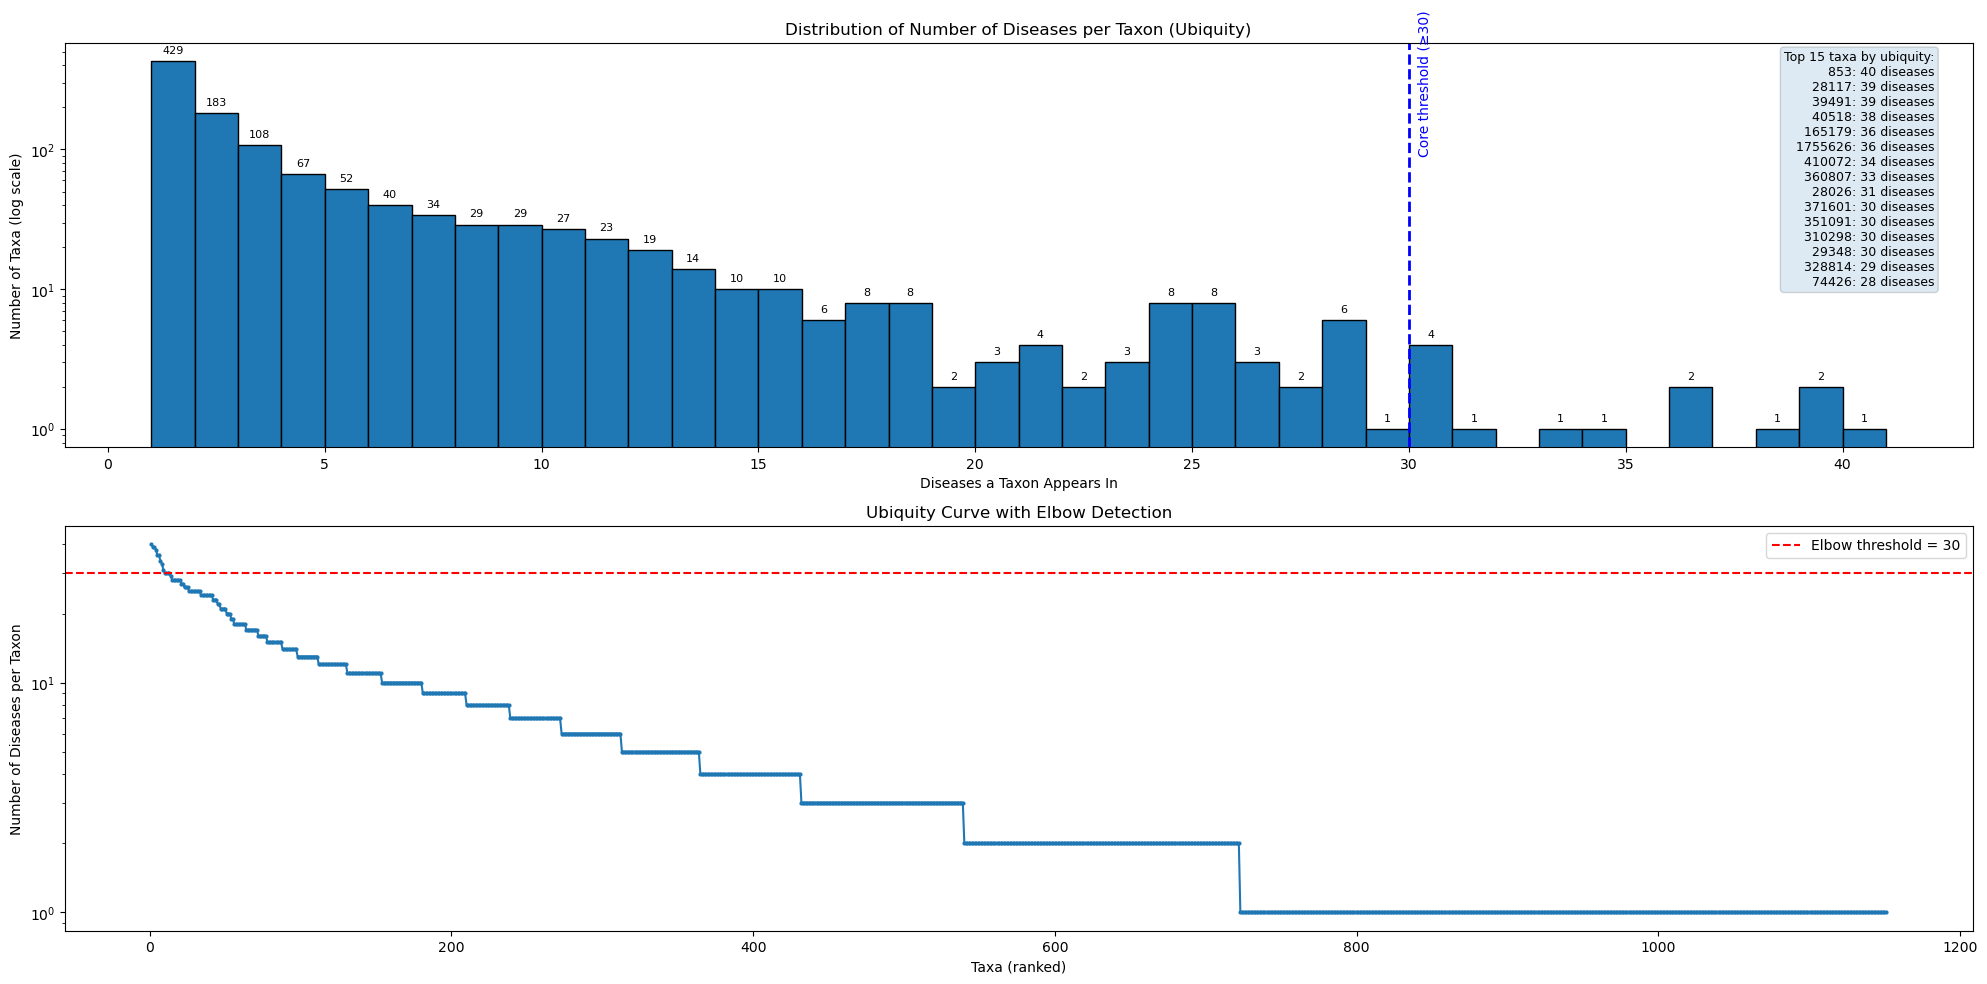

In [5]:
# UBIQUITY FILTERING TO REMOVE COMMON TAXA -- SPECIES LEVEL
# --- CONFIG ---
TOP_N = 15
UBIQ_THRESHOLD = 25  # default, will be replaced by elbow if found
FIGSIZE = (20, 10)

# 1) Ensure unique (disease, taxon)
dfu = df_species_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) KneeLocator to find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None
if elbow_value:
    UBIQ_THRESHOLD = elbow_value

print(f"Elbow-based ubiquity threshold: {UBIQ_THRESHOLD}")

# 4) Prepare figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=FIGSIZE)

# --- Subplot 1: Histogram ---
bins = np.arange(1, taxon_ubiquity.max() + 2)
counts, edges, patches = axes[0].hist(taxon_ubiquity, bins=bins, edgecolor='black')
axes[0].set_yscale("log")
axes[0].set_xlabel("Diseases a Taxon Appears In")
axes[0].set_ylabel("Number of Taxa (log scale)")
axes[0].set_title("Distribution of Number of Diseases per Taxon (Ubiquity)")

# Add labels on top of bars
for count, edge in zip(counts, edges):
    if count > 0:
        axes[0].text(edge + 0.5, count * 1.1,
                     f"{int(count)}", ha="center", va="bottom", fontsize=8)

# Threshold line
axes[0].axvline(UBIQ_THRESHOLD, linestyle="--", linewidth=2, color='blue')
axes[0].text(UBIQ_THRESHOLD + 0.2, max(counts[counts > 0]) * 0.7,
             f"Core threshold (≥{UBIQ_THRESHOLD})",
             rotation=90, va="center", color='blue')

# Top taxa annotation
top_rows = taxon_ubiquity.head(TOP_N)
top_text = "\n".join([f"{int(tid)}: {ub} diseases" for tid, ub in top_rows.items()])
props = dict(boxstyle="round", alpha=0.15)
axes[0].text(0.98, 0.98, f"Top {TOP_N} taxa by ubiquity:\n{top_text}",
             transform=axes[0].transAxes, ha="right", va="top", bbox=props, fontsize=9)

# --- Subplot 2: Ubiquity rank curve ---
axes[1].plot(x, y, marker='o', markersize=2)
if elbow_value:
    axes[1].axhline(elbow_value, color='red', linestyle='--',
                    label=f"Elbow threshold = {elbow_value}")
axes[1].set_yscale("log")
axes[1].set_xlabel("Taxa (ranked)")
axes[1].set_ylabel("Number of Diseases per Taxon")
axes[1].set_title("Ubiquity Curve with Elbow Detection")
axes[1].legend()

# --- Show only ---
plt.tight_layout()
plt.show()


In [6]:
# POST UBIQUITY FILTERING SUMMARY
# 1) Ensure unique (disease, taxon) pairs
dfu = df_species_network[["disease", "ncbi_taxon_id"]].drop_duplicates()

# 2) Calculate ubiquity (number of distinct diseases per taxon)
taxon_ubiquity = (
    dfu.groupby("ncbi_taxon_id")["disease"]
       .nunique()
       .sort_values(ascending=False)
       .rename("ubiquity")
)

# 3) Find elbow threshold
x = np.arange(1, len(taxon_ubiquity) + 1)
y = taxon_ubiquity.values
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_value = int(y[kneedle.knee - 1]) if kneedle.knee is not None else None


# 4) Remove high-ubiquity taxa (keep only those BELOW threshold)
if elbow_value:
    low_ubiquity_taxa = taxon_ubiquity[taxon_ubiquity < elbow_value].index
    df_species_network_filtered = df_species_network[df_species_network["ncbi_taxon_id"].isin(low_ubiquity_taxa)]
else:
    df_species_network_filtered = df_species_network.copy()


# =====================================================
# 5) Detailed Filtering Summary
# =====================================================
total_taxa = df_species_network["ncbi_taxon_id"].nunique()
filtered_taxa = df_species_network_filtered["ncbi_taxon_id"].nunique()
removed_taxa = total_taxa - filtered_taxa

total_diseases = df_species_network["disease"].nunique()
diseases_after = df_species_network_filtered["disease"].nunique()

avg_ubiq_after = (
    dfu[dfu["ncbi_taxon_id"].isin(df_species_network_filtered["ncbi_taxon_id"])]
    .groupby("ncbi_taxon_id")["disease"]
    .nunique()
    .mean()
)

print("\n=== Ubiquity Filtering Summary ===")
print(f"Ubiquity threshold applied: {elbow_value if elbow_value else 'None'}")
print(f"Original total rows: {len(df_species_network):,}")
print(f"Remaining rows after filtering: {len(df_species_network_filtered):,}")
print(f"Original number of unique taxa: {total_taxa:,}")
print(f"Number of unique taxa removed: {removed_taxa:,} ({removed_taxa/total_taxa:.1%} of taxa)")
print(f"Number of unique taxa kept: {filtered_taxa:,}")
print(f"Original number of diseases: {total_diseases:,}")
print(f"Diseases retained after filtering: {diseases_after:,} ({diseases_after/total_diseases:.1%} of diseases still connected)")
print(f"Average ubiquity (before): {taxon_ubiquity.mean():.2f} diseases/taxon")
print(f"Average ubiquity (after): {avg_ubiq_after:.2f} diseases/taxon")

# Show top 5 most ubiquitous taxa removed
if elbow_value:
    removed_taxa_ids = taxon_ubiquity[taxon_ubiquity >= elbow_value].head(5)
    print("\nTop 5 most ubiquitous taxa removed:")
    for tid, ubiq in removed_taxa_ids.items():
        print(f"  Taxon {tid}: {ubiq} diseases")




=== Ubiquity Filtering Summary ===
Ubiquity threshold applied: 30
Original total rows: 5,679
Remaining rows after filtering: 5,233
Original number of unique taxa: 1,151
Number of unique taxa removed: 13 (1.1% of taxa)
Number of unique taxa kept: 1,138
Original number of diseases: 65
Diseases retained after filtering: 65 (100.0% of diseases still connected)
Average ubiquity (before): 4.93 diseases/taxon
Average ubiquity (after): 4.60 diseases/taxon

Top 5 most ubiquitous taxa removed:
  Taxon 853: 40 diseases
  Taxon 28117: 39 diseases
  Taxon 39491: 39 diseases
  Taxon 40518: 38 diseases
  Taxon 165179: 36 diseases



Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: 1203  |  Edges: 5233
  • Diseases (U): 65
  • Taxa     (V): 1138

Edge density (E / U×V): 0.070745  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: 80.508  |  median: 49.000
  min:  13   |  max:    271
  std:  61.317   |  IQR:    78.000
  Q25:  35.000   |  Q75:    113.000

Degree stats — Taxa (neighbors per taxon)
  mean: 4.598     |  median: 2.000
  min:  1      |  max:    29
  std:  5.455      |  IQR:    5.000
  Q25:  1.000      |  Q75:    6.000



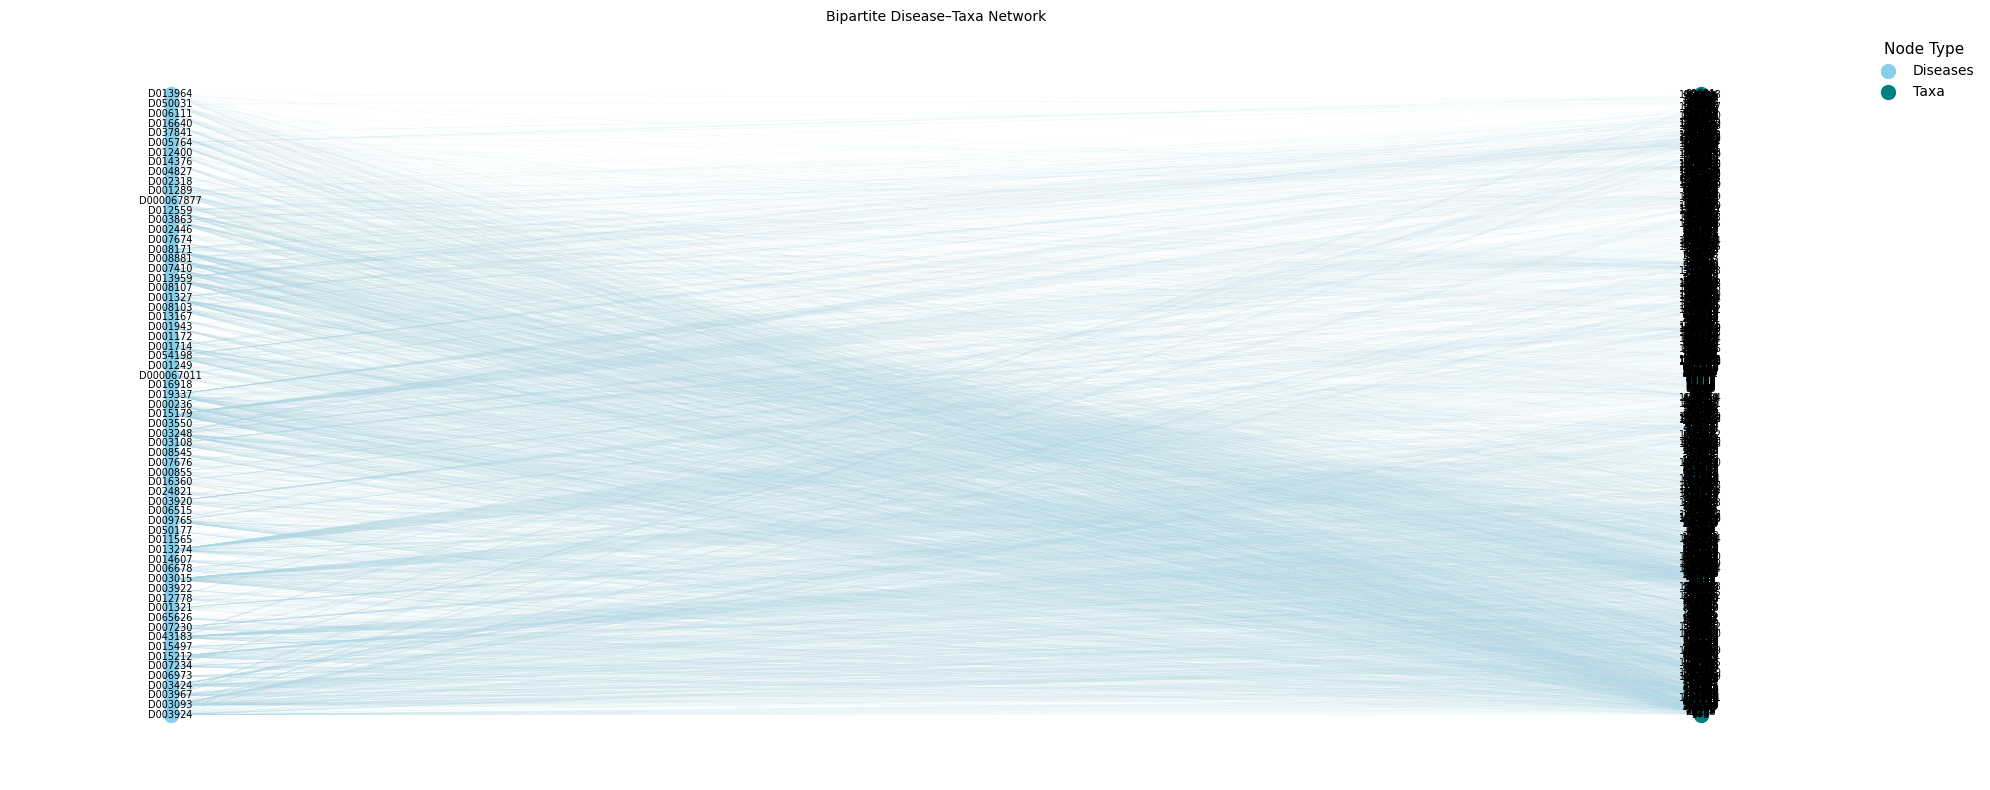

In [7]:
# === Build bipartite ===
B = nx.Graph()

# unique nodes for each layer
diseases = df_species_network_filtered['disease'].unique()
taxa = df_species_network_filtered['ncbi_taxon_id'].astype(str).unique()

# add nodes with bipartite attribute
B.add_nodes_from(diseases, bipartite=0)  # layer 0 = diseases
B.add_nodes_from(taxa, bipartite=1)      # layer 1 = taxa

# add edges
edges = df_species_network_filtered[['disease', 'ncbi_taxon_id']].drop_duplicates()
edges['ncbi_taxon_id'] = edges['ncbi_taxon_id'].astype(str)
B.add_edges_from(edges.values.tolist())

# === Separate nodes ===
disease_nodes = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 0]
taxa_nodes    = [n for n in B.nodes() if B.nodes[n]['bipartite'] == 1]

# === Density (bipartite) ===
E = B.number_of_edges()
U = len(disease_nodes)
V = len(taxa_nodes)
max_possible_edges = U * V
density = E / max_possible_edges if max_possible_edges > 0 else float('nan')

# === Degree stats helper ===
def degree_stats(G, nodes):
    deg = np.array([G.degree(n) for n in nodes], dtype=float)
    if deg.size == 0:
        return dict(mean=np.nan, median=np.nan, min=np.nan, max=np.nan,
                    std=np.nan, q25=np.nan, q75=np.nan, iqr=np.nan)
    return dict(
        mean   = float(deg.mean()),
        median = float(np.median(deg)),
        min    = float(deg.min()),
        max    = float(deg.max()),
        std    = float(deg.std(ddof=0)),
        q25    = float(np.percentile(deg, 25)),
        q75    = float(np.percentile(deg, 75)),
        iqr    = float(np.percentile(deg, 75) - np.percentile(deg, 25)),
    )

disease_deg = degree_stats(B, disease_nodes)
taxa_deg    = degree_stats(B, taxa_nodes)

# === Descriptive summary ===
print(f"""
Bipartite Disease–Taxa Network Summary
--------------------------------------
Nodes: {B.number_of_nodes()}  |  Edges: {E}
  • Diseases (U): {U}
  • Taxa     (V): {V}

Edge density (E / U×V): {density:.6f}  (range: 0 = no edges, 1 = fully connected)

Degree stats — Diseases (neighbors per disease)
  mean: {disease_deg['mean']:.3f}  |  median: {disease_deg['median']:.3f}
  min:  {disease_deg['min']:.0f}   |  max:    {disease_deg['max']:.0f}
  std:  {disease_deg['std']:.3f}   |  IQR:    {disease_deg['iqr']:.3f}
  Q25:  {disease_deg['q25']:.3f}   |  Q75:    {disease_deg['q75']:.3f}

Degree stats — Taxa (neighbors per taxon)
  mean: {taxa_deg['mean']:.3f}     |  median: {taxa_deg['median']:.3f}
  min:  {taxa_deg['min']:.0f}      |  max:    {taxa_deg['max']:.0f}
  std:  {taxa_deg['std']:.3f}      |  IQR:    {taxa_deg['iqr']:.3f}
  Q25:  {taxa_deg['q25']:.3f}      |  Q75:    {taxa_deg['q75']:.3f}
""")

# === Plot ===
pos = nx.bipartite_layout(B, disease_nodes)

plt.figure(figsize=(20, 8))
nx.draw_networkx_nodes(B, pos, nodelist=disease_nodes, node_color="skyblue", node_size=100, label="Diseases")
nx.draw_networkx_nodes(B, pos, nodelist=taxa_nodes, node_color="teal",     node_size=100, label="Taxa")
nx.draw_networkx_edges(B, pos, alpha=0.35, width=0.1, edge_color='lightblue')
nx.draw_networkx_labels(B, pos, font_size=7)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=10,
           title="Node Type", title_fontsize=11)
plt.axis("off")
plt.title("Bipartite Disease–Taxa Network", fontsize=10)
plt.tight_layout()
plt.show()


### <span style="color:teal"> __UNIPARTITE PROJECTION__
<span style="color:white"> __1. DISEASE-DISEASE PROJECTION__
<span style="color:white"> __2. TAXON-TAXON PROJECTION__


Disease–Disease Unipartite Summary:
- Nodes: 65
- Edges: 2031
- Density: 0.9764
- Degree: mean 62.49, median 63.00, min 50, max 64


Taxa–Taxa Unipartite Summary:
- Nodes: 1138
- Edges: 192235
- Density: 0.2971
- Degree: mean 337.85, median 282.00, min 32, max 964



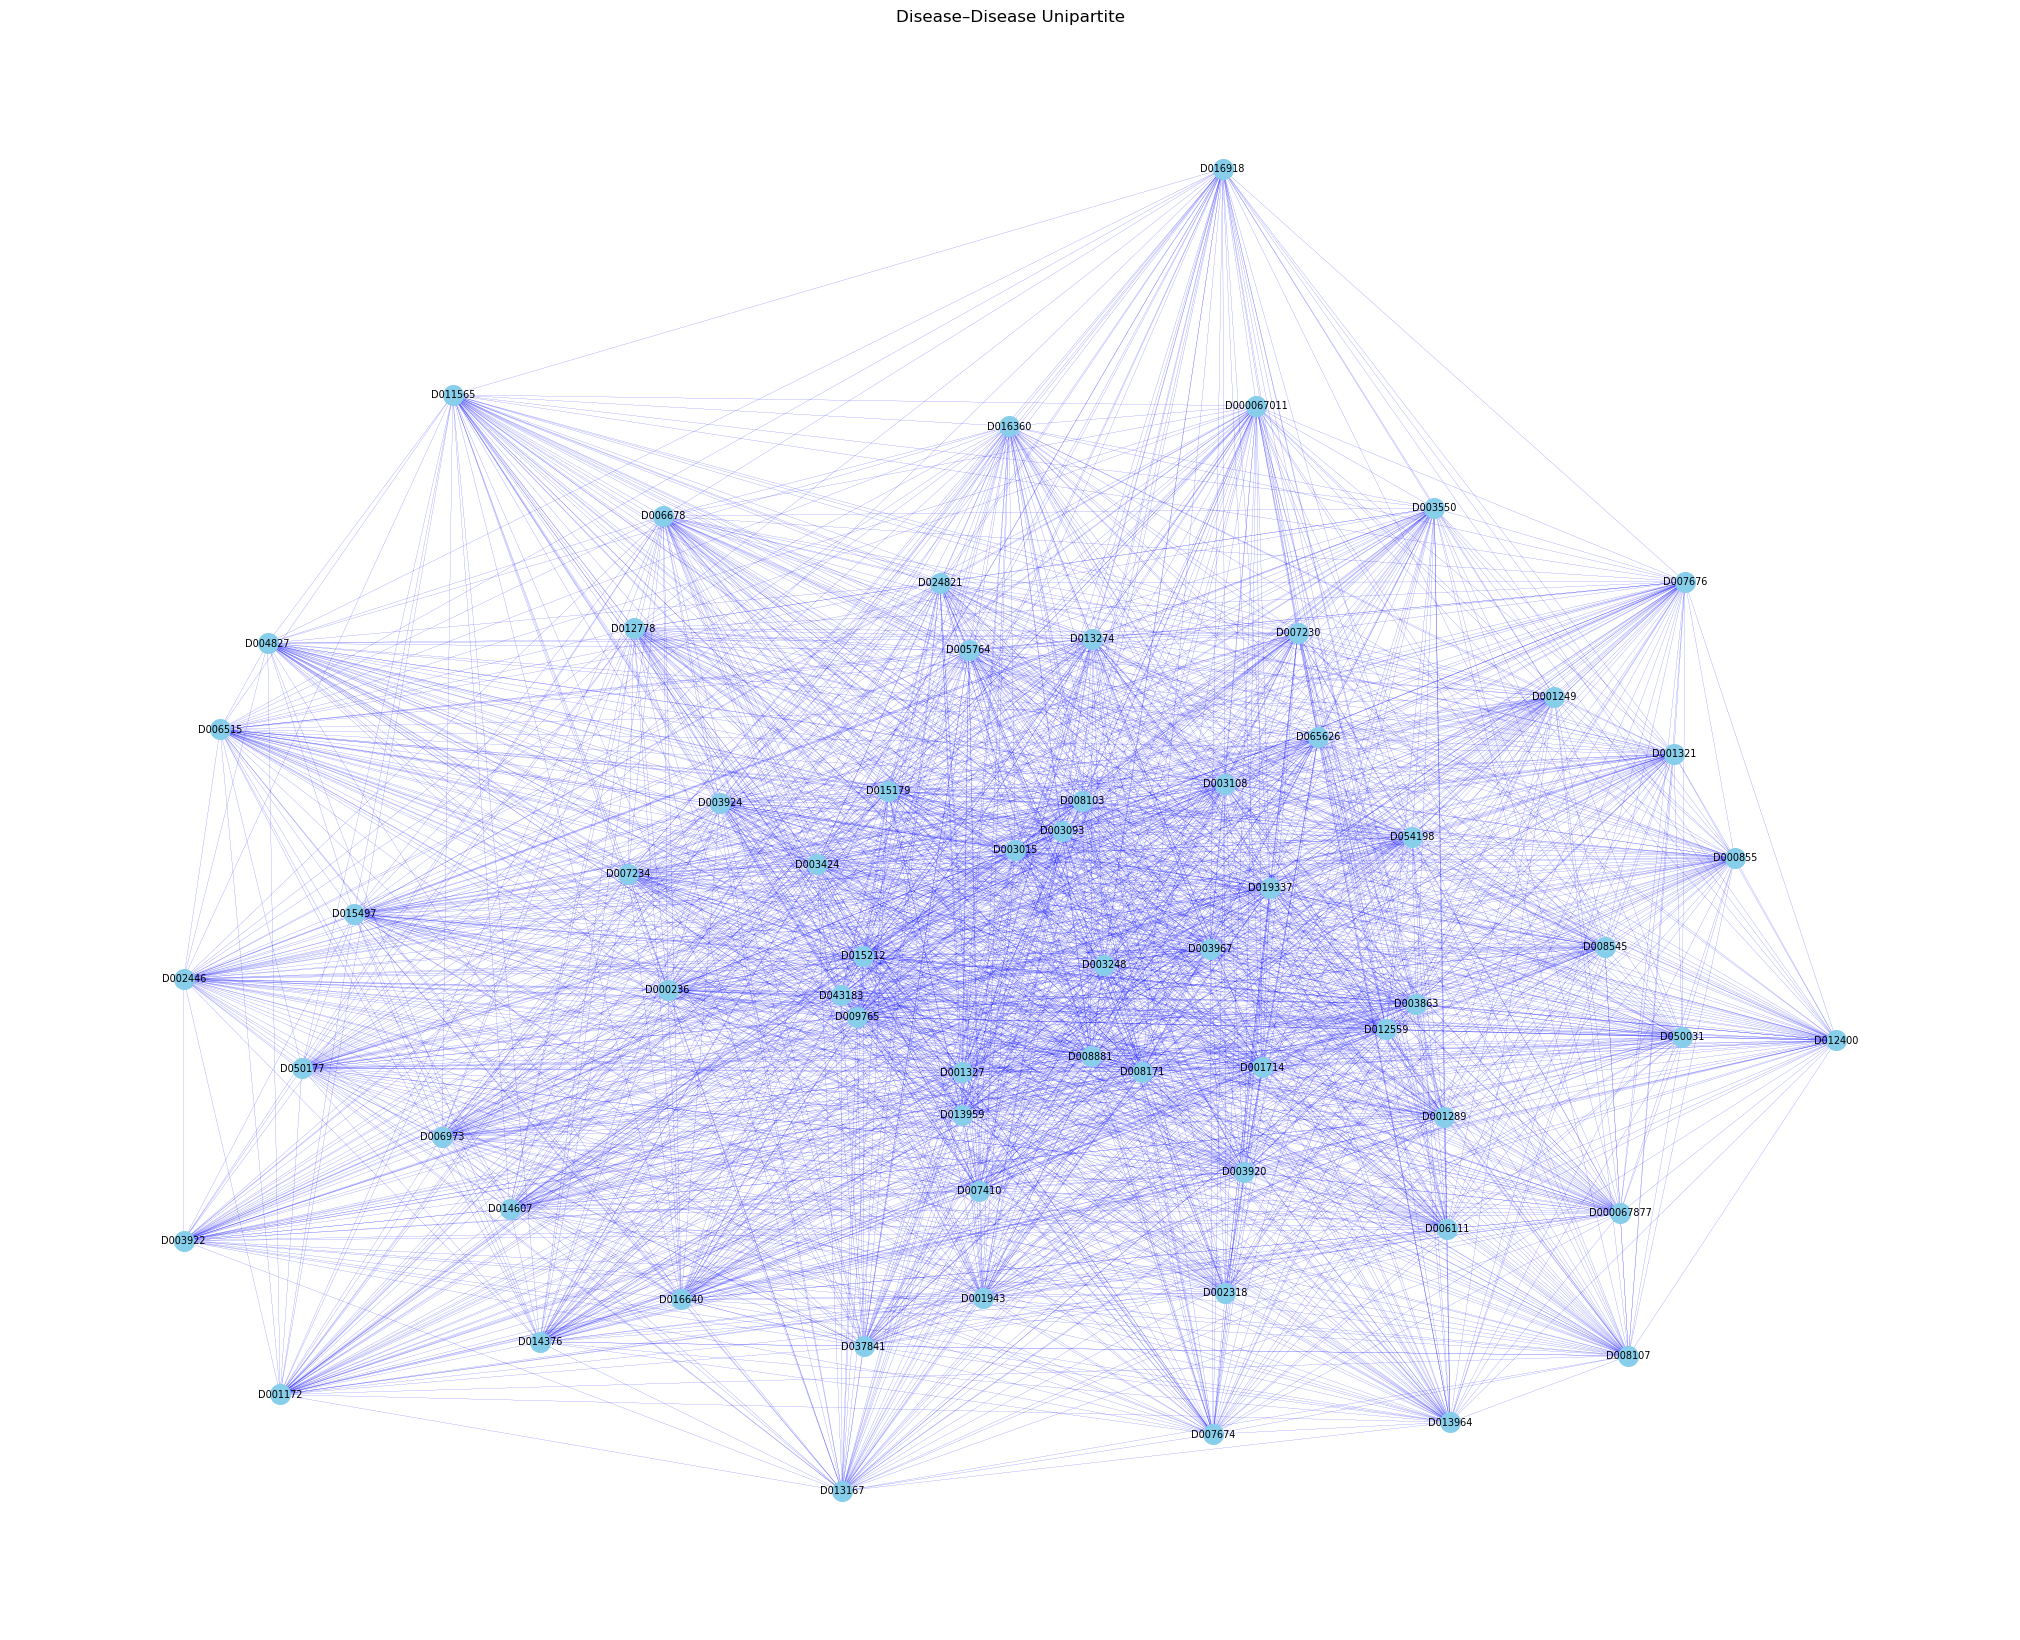

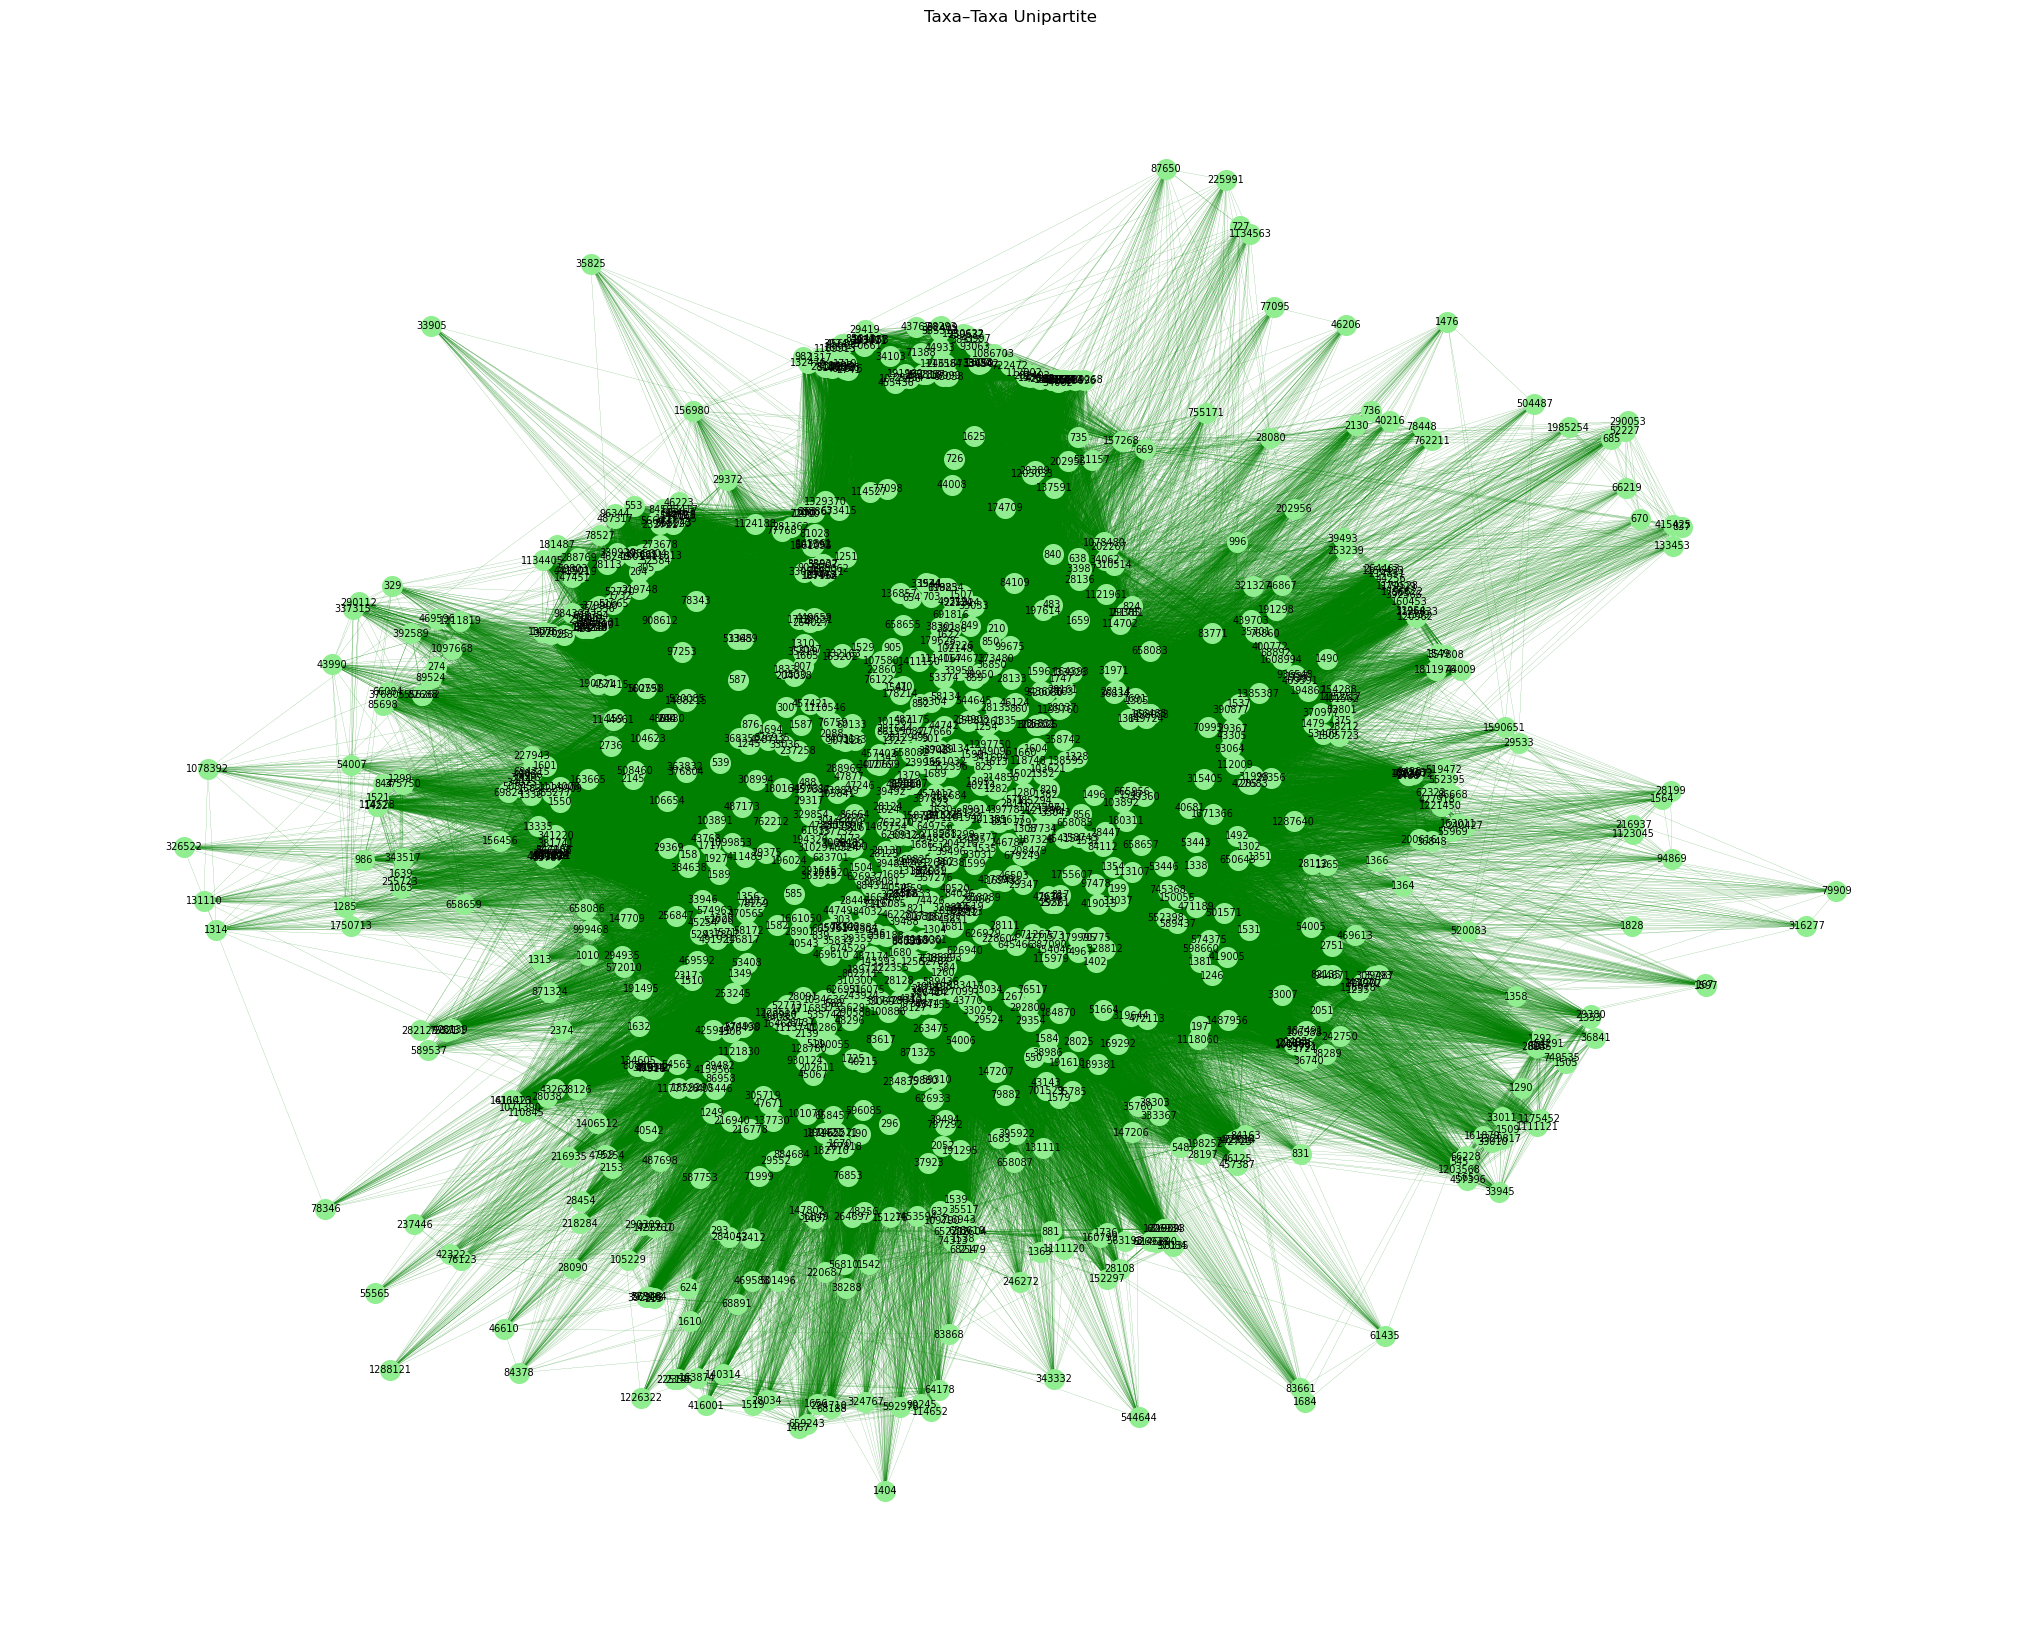

In [8]:
# Separate the two node sets from B
disease_nodes = [n for n, d in B.nodes(data=True) if d["bipartite"] == 0]
taxa_nodes    = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]

# Weighted projections
G_disease = bipartite.weighted_projected_graph(B, disease_nodes)
G_taxa    = bipartite.weighted_projected_graph(B, taxa_nodes)

def describe_graph(G, name):
    n = G.number_of_nodes()
    e = G.number_of_edges()
    max_possible_edges = n * (n - 1) / 2
    density = e / max_possible_edges if max_possible_edges else 0
    deg = np.array([G.degree(n) for n in G.nodes()])
    print(f"""
{name} Summary:
- Nodes: {n}
- Edges: {e}
- Density: {density:.4f}
- Degree: mean {deg.mean():.2f}, median {np.median(deg):.2f}, min {deg.min()}, max {deg.max()}
""")

# Print summaries
describe_graph(G_disease, "Disease–Disease Unipartite")
describe_graph(G_taxa, "Taxa–Taxa Unipartite")

# Plot Disease–Disease
plt.figure(figsize=(20, 16))
nx.draw(G_disease, with_labels=True, node_color="skyblue",
        node_size=200, font_size=7, width=0.1, edge_color='blue')
plt.title("Disease–Disease Unipartite")
plt.axis("off")
plt.show()

# Plot Taxa–Taxa
plt.figure(figsize=(20, 16))
nx.draw(G_taxa, with_labels=True, node_color="lightgreen",
        node_size=200, font_size=7, width=0.1, edge_color='green')
plt.title("Taxa–Taxa Unipartite")
plt.axis("off")
plt.show()


# Save bipartite
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/bipartite_species_network.gpickle", "wb") as f:
    pickle.dump(B, f)

# Save unipartite (disease)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/unipartite_disease_species.gpickle", "wb") as f:
    pickle.dump(G_disease, f)

# Save unipartite (taxa)
with open("/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/gmp_jms/unipartite_taxa_species.gpickle", "wb") as f:
    pickle.dump(G_taxa, f)


### <span style="color:teal"> __UNIPARTITE DISEASE-DISEASE THRESHOLD EVALUATION FOR NODES PROJECTION AT SPECIES LEVEL__

In [9]:
# AT DISEASE-DISEASE PROJECTION - SPECIES LEVEL
# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95, 99]   # θ candidates

# =========================
# 2) Evaluate thresholds
# =========================
weights = np.array([d.get("weight", 1.0) for _, _, d in G_disease.edges(data=True)], dtype=float)

df_rows = []
for p in PERCENTILES:
    # threshold at percentile p
    theta = np.percentile(weights, p)
    Gt = nx.Graph(((u, v, d) for u, v, d in G_disease.edges(data=True) if d.get("weight", 1.0) >= theta))
    
    n_nodes = Gt.number_of_nodes()
    n_edges = Gt.number_of_edges()
    max_edges = n_nodes * (n_nodes - 1) // 2
    density = n_edges / max_edges if max_edges > 0 else None

    df_rows.append({
        "percentile": p,
        "theta": theta,
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "density": density
    })

df_summary = pd.DataFrame(df_rows)

# =========================
# 3) Output
# =========================
print("\n=== Simplified Threshold Evaluation for disease-disease projection at Species Level (Nodes, Edges, Density) ===")
print(df_summary.to_string(index=False))


=== Simplified Threshold Evaluation for disease-disease projection at Species Level (Nodes, Edges, Density) ===
 percentile  theta  n_nodes  n_edges  density
          0    1.0       65     2031 0.976442
         50    8.0       64     1111 0.551091
         60   11.0       63      834 0.427035
         70   14.0       59      628 0.367037
         80   18.0       53      425 0.308418
         85   22.0       44      309 0.326638
         90   29.0       31      213 0.458065
         95   43.0       23      104 0.411067
         99   75.1       12       21 0.318182


In [10]:
# Threshold at weight >= theta
theta = 0
G_disease_thresholded = G_disease.edge_subgraph(
    [(u, v) for u, v, d in G_disease.edges(data=True) if d.get("weight", 0) >= theta]
).copy()

# Remove isolates
isolates = [n for n, deg in G_disease_thresholded.degree() if deg == 0]
G_disease_thresholded.remove_nodes_from(isolates)

# --- Compute centrality metrics on your genus-level graph ---
metrics = {
    "Degree": dict(G_disease_thresholded.degree()),
    "Degree Centrality": nx.degree_centrality(G_disease_thresholded),
    "Closeness Centrality": nx.closeness_centrality(G_disease_thresholded),
    "Betweenness Centrality": nx.betweenness_centrality(G_disease_thresholded, normalized=True),
    "Eigenvector Centrality": nx.eigenvector_centrality(G_disease_thresholded, max_iter=1000),
    "Harmonic Centrality": nx.harmonic_centrality(G_disease_thresholded)
}


# =========================
# Combine metrics into a DataFrame
# =========================
df_metrics = pd.DataFrame(metrics)

# Map node IDs to disease names in the metrics DataFrame
df_metrics_named = df_metrics.copy()
df_metrics_named.index = df_metrics_named.index.map(lambda x: disease_dict.get(str(x), x))

# Sort by Degree and take top 10
df_metrics_top10_named = df_metrics_named.sort_values(by="Degree", ascending=False).head(10)

# Display
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
print("\n=== Top 10 Nodes by Degree (after thresholding) ===")
print(df_metrics_top10_named)



=== Top 10 Nodes by Degree (after thresholding) ===
                             Degree  Degree Centrality  Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  Harmonic Centrality
Diabetes Mellitus, Type 2        64                1.0                   1.0                0.000463                 0.12666                 64.0
Colitis, Ulcerative              64                1.0                   1.0                0.000463                 0.12666                 64.0
Diarrhea                         64                1.0                   1.0                0.000463                 0.12666                 64.0
Crohn Disease                    64                1.0                   1.0                0.000463                 0.12666                 64.0
Infant, Premature                64                1.0                   1.0                0.000463                 0.12666                 64.0
Irritable Bowel Syndrome         64                1.0                 

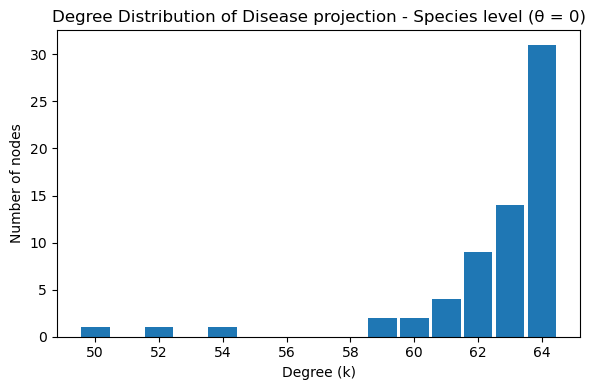

R (Log-likelihood ratio) = -82.88696891619459, p-value = 8.088820836618254e-08, alpha = 7.219291913784932, xmin = 54.0
KS = 0.4551263704778769
Number of nodes in the tail (k >= xmin = 54.0): 63


Calculating best minimal value for power law fit
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


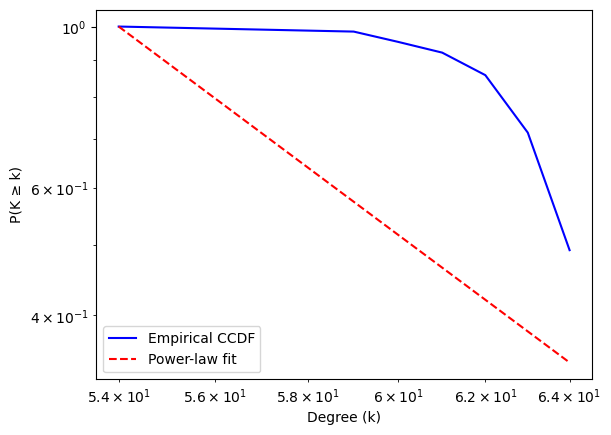

Calculating best minimal value for power law fit


R (Log-likelihood ratio) = 4.234560370547097, p-value = 0.0036122599525737487, alpha = 1.0000928296000269, lambda = 0.09269780010709122, xmin = 54.0
KS = 0.45078927593484824
Number of nodes in the tail (k >= xmin = 54.0): 63


Assuming nested distributions


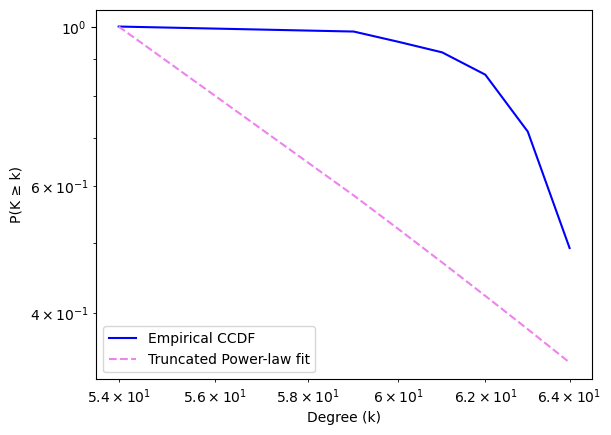

Power-law: alpha=7.219291913784932, xmin=54.0
Lognormal: mu=4.140463431961903, sigma=0.027934939495462614
Likelihood ratio R = -82.88696891619459, p-value = 8.088820836618254e-08


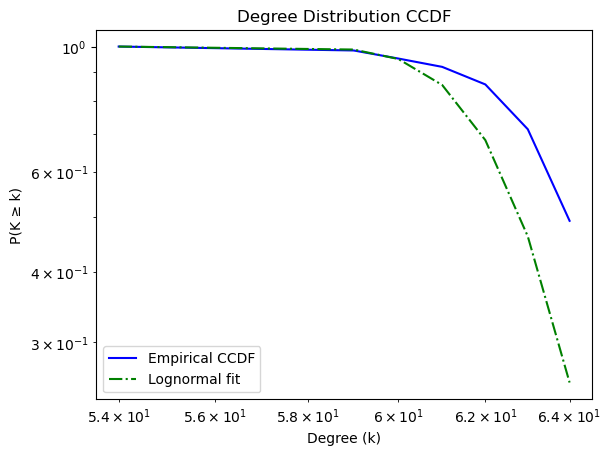

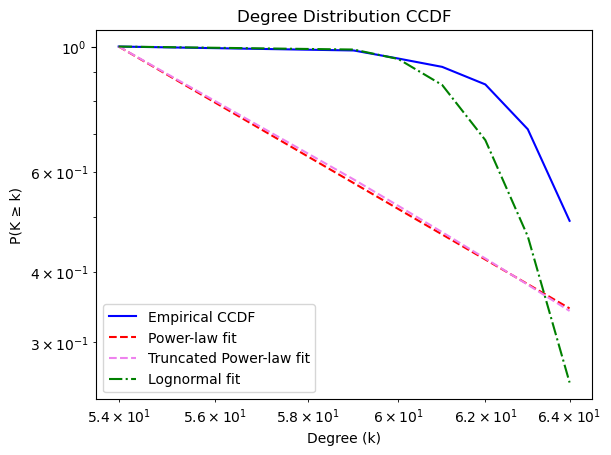

In [11]:
 # === STEP 1: Degree list ===
degrees = np.array([deg for _, deg in G_disease_thresholded.degree()], dtype=int)
deg = degrees[degrees > 0]

# === STEP 2: Plot degree histogram ===
vals, counts = np.unique(deg, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(vals, counts, width=0.9, align="center")
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes")
plt.title(f"Degree Distribution of Disease projection - Species level (θ = {theta})")
plt.tight_layout()
plt.show()

# === STEP 3:POWER-LAW fit using powerlaw package
fit = powerlaw.Fit(degrees, xmin=None, discrete=True)  # discrete=True is important for network degrees
alpha = fit.alpha        # estimated exponent
xmin = fit.xmin          # estimated minimum degree for the power-law behavior
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"R (Log-likelihood ratio) = {R}, p-value = {p}, alpha = {alpha}, xmin = {xmin}")
ks_distance = fit.power_law.KS()  # returns the KS statistic for the fitted power-law
print("KS =", ks_distance)
# degrees is your array/list of node degrees
tail_nodes = [k for k in degrees if k >= fit.xmin]
n_tail_nodes = len(tail_nodes)
print(f"Number of nodes in the tail (k >= xmin = {fit.xmin}): {n_tail_nodes}")

# Plot CCDF
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power-law fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.legend()
plt.show()

# === STEP 4: POWER-LAW with exponential cutoff (truncated power-law) ===
fit_trunc = powerlaw.Fit(degrees, xmin=None, discrete=True)
# Fit truncated power-law
alpha_trunc, lambda_trunc = fit_trunc.truncated_power_law.parameter1, fit_trunc.truncated_power_law.parameter2
xmin_trunc = fit_trunc.xmin
# Compare truncated power-law with pure power-law
R, p = fit_trunc.distribution_compare('truncated_power_law', 'power_law')

print(f"R (Log-likelihood ratio) = {R}, p-value = {p}, alpha = {alpha_trunc}, lambda = {lambda_trunc}, xmin = {xmin_trunc}")
ks_distance = fit_trunc.truncated_power_law.KS()
print("KS =", ks_distance)
# degrees is your array/list of node degrees
tail_nodes = [k for k in degrees if k >= fit.xmin]
n_tail_nodes = len(tail_nodes)
print(f"Number of nodes in the tail (k >= xmin = {fit.xmin}): {n_tail_nodes}")

# Plot CCDF
fig = fit_trunc.plot_ccdf(color='blue', label='Empirical CCDF')
fit_trunc.truncated_power_law.plot_ccdf(ax=fig, color='violet', linestyle='--', label='Truncated Power-law fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.legend()
plt.show()

#  === STEP 5: LOG-NORMAL ===
# Fit lognormal (automatically fits to tail >= xmin)
lognormal_fit = fit.lognormal
mu, sigma = lognormal_fit.mu, lognormal_fit.sigma

print(f"Power-law: alpha={alpha}, xmin={xmin}")
print(f"Lognormal: mu={mu}, sigma={sigma}")
# Compare power-law vs lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio R = {R}, p-value = {p}")
# --- Plot CCDFs ---
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')      # Empirical
fit.lognormal.plot_ccdf(ax=fig, color='green', linestyle='-.', label='Lognormal fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title("Degree Distribution CCDF")
plt.legend()
plt.show()


# --- Plot CCDFs ---
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')      # Empirical
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power-law fit')
fit_trunc.truncated_power_law.plot_ccdf(ax=fig, color='violet', linestyle='--', label='Truncated Power-law fit')
fit.lognormal.plot_ccdf(ax=fig, color='green', linestyle='-.', label='Lognormal fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title("Degree Distribution CCDF")
plt.legend()
plt.show()


### <span style="color:teal"> __UNIPARTITE TAXA-TAXA THRESHOLD EVALUATION FOR NODES PROJECTION AT SPECIES LEVEL__

In [12]:
# TAXA-TAXA PROJECTION - SPECIES LEVEL
# =========================
# CONFIG
# =========================
PERCENTILES = [0, 50, 60, 70, 80, 85, 90, 95, 99, 99.5]   # θ candidates

# =========================
# 2) Evaluate thresholds
# =========================
weights = np.array([d.get("weight", 1.0) for _, _, d in G_taxa.edges(data=True)], dtype=float)

df_rows = []
for p in PERCENTILES:
    # threshold at percentile p
    theta = np.percentile(weights, p)
    Gt = nx.Graph(((u, v, d) for u, v, d in G_taxa.edges(data=True) if d.get("weight", 1.0) >= theta))
    
    n_nodes = Gt.number_of_nodes()
    n_edges = Gt.number_of_edges()
    max_edges = n_nodes * (n_nodes - 1) // 2
    density = n_edges / max_edges if max_edges > 0 else None

    df_rows.append({
        "percentile": p,
        "theta": theta,
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "density": density
    })

df_summary = pd.DataFrame(df_rows)

# =========================
# 3) Output
# =========================
print("\n=== Simplified Threshold Evaluation for taxa-taxa projection at Species Level(Nodes, Edges, Density) ===")
print(df_summary.to_string(index=False))


=== Simplified Threshold Evaluation for taxa-taxa projection at Species Level(Nodes, Edges, Density) ===
 percentile  theta  n_nodes  n_edges  density
        0.0    1.0     1138   192235 0.297139
       50.0    1.0     1138   192235 0.297139
       60.0    1.0     1138   192235 0.297139
       70.0    2.0      709    58920 0.234754
       80.0    2.0      709    58920 0.234754
       85.0    2.0      709    58920 0.234754
       90.0    3.0      526    28801 0.208590
       95.0    5.0      334    10833 0.194800
       99.0    9.0      148     2319 0.213183
       99.5   11.0       97     1101 0.236469


In [13]:
# Threshold at weight >= theta
theta = 0
G_taxa_thresholded = G_taxa.edge_subgraph(
    [(u, v) for u, v, d in G_taxa.edges(data=True) if d.get("weight", 0) >= theta]
).copy()

# Remove isolates
isolates = [n for n, deg in G_taxa_thresholded.degree() if deg == 0]
G_taxa_thresholded.remove_nodes_from(isolates)

# --- Compute centrality metrics on your genus-level graph ---
metrics = {
    "Degree": dict(G_taxa_thresholded.degree()),
    "Degree Centrality": nx.degree_centrality(G_taxa_thresholded),
    "Closeness Centrality": nx.closeness_centrality(G_taxa_thresholded),
    "Betweenness Centrality": nx.betweenness_centrality(G_taxa_thresholded, normalized=True),
    "Eigenvector Centrality": nx.eigenvector_centrality(G_taxa_thresholded, max_iter=1000),
    "Harmonic Centrality": nx.harmonic_centrality(G_taxa_thresholded)
}


# =========================
# Combine metrics into a DataFrame
# =========================
df_metrics = pd.DataFrame(metrics)

# Map node IDs to disease names in the metrics DataFrame
df_metrics_named = df_metrics.copy()
df_metrics_named.index = df_metrics_named.index.map(lambda x: taxon_dict.get(str(x), x))

# Sort by Degree and take top 10
df_metrics_top10_named = df_metrics_named.sort_values(by="Degree", ascending=False).head(10)

# Display
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
print("\n=== Top 10 Nodes by Degree (after thresholding) ===")
print(df_metrics_top10_named)



=== Top 10 Nodes by Degree (after thresholding) ===
                            Degree  Degree Centrality  Closeness Centrality  Betweenness Centrality  Eigenvector Centrality  Harmonic Centrality
Barnesiella viscericola        964           0.847845              0.867939                0.006780                0.061417               1050.5
Phocaeicola dorei              956           0.840809              0.862671                0.007751                0.060426               1046.5
Bifidobacterium breve          915           0.804749              0.836645                0.006359                0.059308               1026.0
[Ruminococcus] torques         914           0.803870              0.836029                0.005316                0.059754               1025.5
Blautia glucerasea             904           0.795075              0.829927                0.005093                0.059705               1020.5
Acetivibrio thermocellus       903           0.794195              0.829322  

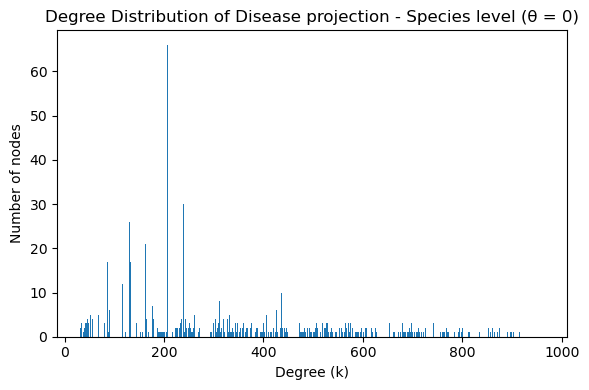

R (Log-likelihood ratio) = -29.879533927580503, p-value = 2.1751766754765595e-06, alpha = 4.593846010260876, xmin = 472.0
KS = 0.11229251478032709
Number of nodes in the tail (k >= xmin = 472.0): 291


Calculating best minimal value for power law fit
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/mnt/iusers01/fatpou01/bmh01/msc-bioinf-2024-2025/h44063jg/miniforge3/envs/mam_myenv/lib/python3.10/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


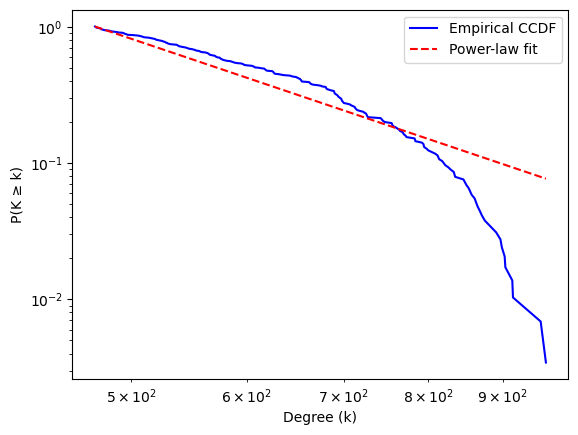

Calculating best minimal value for power law fit
Assuming nested distributions


R (Log-likelihood ratio) = 16.10180206222558, p-value = 1.3883298288774881e-08, alpha = 1.0000060370571093, lambda = 0.004825505443355451, xmin = 472.0
KS = 0.09641912306247058
Number of nodes in the tail (k >= xmin = 472.0): 291


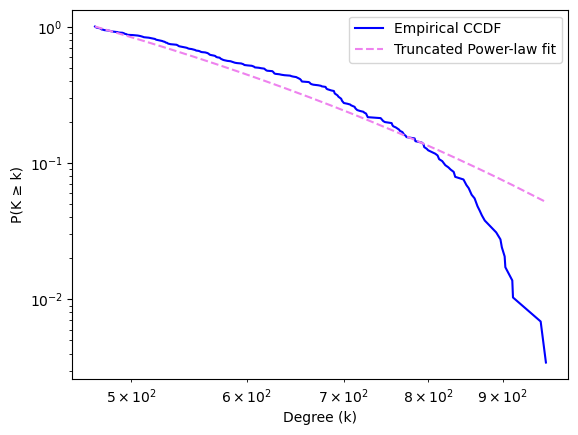

Power-law: alpha=4.593846010260876, xmin=472.0
Lognormal: mu=6.322980260113617, sigma=0.2561345249608691
Likelihood ratio R = -29.879533927580503, p-value = 2.1751766754765595e-06


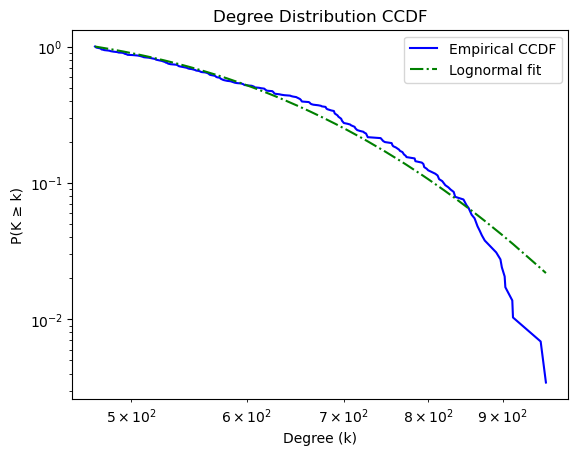

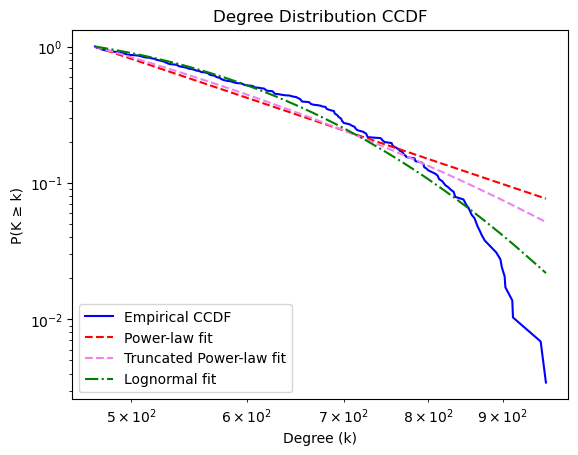

In [14]:
# === STEP 1: Degree list ===
degrees = np.array([deg for _, deg in G_taxa_thresholded.degree()], dtype=int)
deg = degrees[degrees > 0]

# === STEP 2: Plot degree histogram ===
vals, counts = np.unique(deg, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(vals, counts, width=0.9, align="center")
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes")
plt.title(f"Degree Distribution of Disease projection - Species level (θ = {theta})")
plt.tight_layout()
plt.show()

# === STEP 3:POWER-LAW fit using powerlaw package
fit = powerlaw.Fit(degrees, xmin=None, discrete=True)  # discrete=True is important for network degrees
alpha = fit.alpha        # estimated exponent
xmin = fit.xmin          # estimated minimum degree for the power-law behavior
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"R (Log-likelihood ratio) = {R}, p-value = {p}, alpha = {alpha}, xmin = {xmin}")
ks_distance = fit.power_law.KS()  # returns the KS statistic for the fitted power-law
print("KS =", ks_distance)
# degrees is your array/list of node degrees
tail_nodes = [k for k in degrees if k >= fit.xmin]
n_tail_nodes = len(tail_nodes)
print(f"Number of nodes in the tail (k >= xmin = {fit.xmin}): {n_tail_nodes}")

# Plot CCDF
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power-law fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.legend()
plt.show()

# === STEP 4: POWER-LAW with exponential cutoff (truncated power-law) ===
fit_trunc = powerlaw.Fit(degrees, xmin=None, discrete=True)
# Fit truncated power-law
alpha_trunc, lambda_trunc = fit_trunc.truncated_power_law.parameter1, fit_trunc.truncated_power_law.parameter2
xmin_trunc = fit_trunc.xmin
# Compare truncated power-law with pure power-law
R, p = fit_trunc.distribution_compare('truncated_power_law', 'power_law')

print(f"R (Log-likelihood ratio) = {R}, p-value = {p}, alpha = {alpha_trunc}, lambda = {lambda_trunc}, xmin = {xmin_trunc}")
ks_distance = fit_trunc.truncated_power_law.KS()
print("KS =", ks_distance)
# degrees is your array/list of node degrees
tail_nodes = [k for k in degrees if k >= fit.xmin]
n_tail_nodes = len(tail_nodes)
print(f"Number of nodes in the tail (k >= xmin = {fit.xmin}): {n_tail_nodes}")

# Plot CCDF
fig = fit_trunc.plot_ccdf(color='blue', label='Empirical CCDF')
fit_trunc.truncated_power_law.plot_ccdf(ax=fig, color='violet', linestyle='--', label='Truncated Power-law fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.legend()
plt.show()

#  === STEP 5: LOG-NORMAL ===
# Fit lognormal (automatically fits to tail >= xmin)
lognormal_fit = fit.lognormal
mu, sigma = lognormal_fit.mu, lognormal_fit.sigma

print(f"Power-law: alpha={alpha}, xmin={xmin}")
print(f"Lognormal: mu={mu}, sigma={sigma}")
# Compare power-law vs lognormal
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Likelihood ratio R = {R}, p-value = {p}")
# --- Plot CCDFs ---
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')      # Empirical
fit.lognormal.plot_ccdf(ax=fig, color='green', linestyle='-.', label='Lognormal fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title("Degree Distribution CCDF")
plt.legend()
plt.show()


# --- Plot CCDFs ---
fig = fit.plot_ccdf(color='blue', label='Empirical CCDF')      # Empirical
fit.power_law.plot_ccdf(ax=fig, color='red', linestyle='--', label='Power-law fit')
fit_trunc.truncated_power_law.plot_ccdf(ax=fig, color='violet', linestyle='--', label='Truncated Power-law fit')
fit.lognormal.plot_ccdf(ax=fig, color='green', linestyle='-.', label='Lognormal fit')
plt.xlabel("Degree (k)")
plt.ylabel("P(K ≥ k)")
plt.title("Degree Distribution CCDF")
plt.legend()
plt.show()
